In [1]:
from tqdm import tqdm
import json
import pandas as pd
from pathlib import Path
import numpy as np

import xgboost as xgb
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.model_selection import GridSearchCV
import torch

In [2]:
split_dir = Path('dataset') / 'biobert_split'

In [3]:
X_train = np.load(split_dir / 'X_train.npy')
X_train_sent = np.load(split_dir / 'X_train_sent.npy')
X_test = np.load(split_dir / 'X_test.npy')
X_test_sent = np.load(split_dir / 'X_test_sent.npy')
y_train = np.load(split_dir / 'y_train.npy')
y_test = np.load(split_dir / 'y_test.npy')

len(X_train), len(X_test), len(y_train), len(y_test), len(X_train_sent), len(X_test_sent)

(338, 85, 338, 85, 338, 85)

In [4]:
X_train = [' '.join(row) for row in X_train]
X_test = [' '.join(row) for row in X_test]

X_train[0], X_test[0]

('em ##etophobia flying fly motion over the years husband 7 – 8 hour books 1 hour na husband regressed every day motion fly feel trapped <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'intense emetophobia freaking out close boba tea stomach ache panic tired few hours later went to sleep woke up house ill fine eat stomach rumble almost 1 in the afternoon 30 minutes sick z ##ofran pep sick <PAD>

In [5]:
skipgram_model = Word2Vec(sentences=X_train, vector_size=64, window=4, min_count=1, sg=1, workers=-1)

In [6]:
train_vec_size = 63

In [7]:
X_train_final = []
X_test_final = []

for i in tqdm(range(len(X_train))):
    text = X_train[i]
    sentiment = X_train_sent[i]

    tokens = text.split()
    vectors = [skipgram_model.wv[token] for token in tokens if token in skipgram_model.wv]

    if len(vectors) > train_vec_size:
        vectors = vectors[:train_vec_size]
    elif len(vectors) < train_vec_size:
        vectors += [np.zeros(64)] * (train_vec_size - len(vectors))

    combined_vector = np.concatenate((np.mean(vectors, axis=0), np.array([sentiment])))

    X_train_final.append(combined_vector)

for i in tqdm(range(len(X_test))):
    text = X_test[i]
    sentiment = X_test_sent[i]

    tokens = text.split()
    vectors = [skipgram_model.wv[token] for token in tokens if token in skipgram_model.wv]

    if len(vectors) > train_vec_size:
        vectors = vectors[:train_vec_size]
    elif len(vectors) < train_vec_size:
        vectors += [np.zeros(64)] * (train_vec_size - len(vectors))

    combined_vector = np.concatenate((np.mean(vectors, axis=0), np.array([sentiment])))

    X_test_final.append(combined_vector)

X_train_final = np.array(X_train_final)
X_train_final = X_train_final.astype(np.float64)
X_test_final = np.array(X_test_final)
X_test_final = X_test_final.astype(np.float64)

len(X_train_final), len(X_test_final), len(y_train), len(y_test)
    

100%|██████████| 85/85 [00:00<00:00, 8489.89it/s]


(338, 85, 338, 85)

In [8]:
n_clusters = len(['Question', 'Needing support - Panic attack', 'Rant', 'Potentially Triggering', 'Does Anyone Else...?', 'Needing support: Just not feeling good'])

In [9]:
labels_mapping = {
    "Question": 0,
    "Needing support - Panic attack": 1,
    "Rant": 2,
    "Potentially Triggering": 3,
    "Does Anyone Else...?": 4,
    "Needing support: Just not feeling good": 5
}

y_train_final = np.array([labels_mapping[label] for label in y_train])
y_test_final = np.array([labels_mapping[label] for label in y_test])

In [10]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_macro',verbose=1, n_jobs=-1)


grid_search.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [11]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [12]:
acc = accuracy_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred, average='macro')
precision = precision_score(y_test_final, y_pred, average='macro')
recall = recall_score(y_test_final, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.2000
F1 Score: 0.1765
Precision: 0.1795
Recall: 0.1798


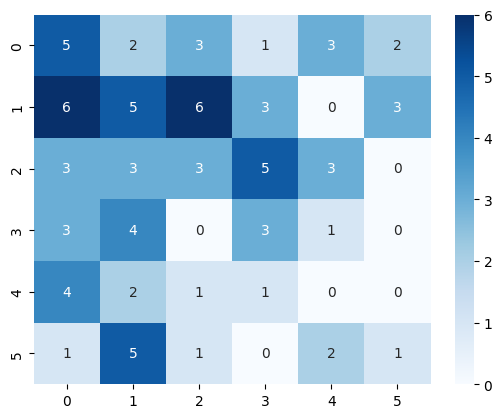

In [13]:
ax = sns.heatmap(confusion_matrix(y_test_final, y_pred), annot=True, fmt='d', cmap='Blues')